In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import operator
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
import zipfile
import os
import PIL
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
from stardist.models import StarDist2D
#from keras_unet_collection import models
import keras
import skimage
from sklearn.cluster import KMeans
import scipy
from PIL import Image
import statistics
import math
import copy
import scipy.stats as stats
import SimpleITK as Sitk
import numba
from numba import njit
import scipy.ndimage as ndimage
import scipy.ndimage as ndi
from skimage import measure
import multiprocessing
from multiprocessing import Pool
from aicsimageio import AICSImage
import matplotlib.pyplot as plt
#import numpy as np
import math
from PIL import Image
import cv2
import skimage
import sklearn
from skimage.filters import threshold_multiotsu
from numba import jit, cuda
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras import layers
from tensorflow.keras.applications import VGG16
import dill
from skimage.morphology import disk
import pickle
from matplotlib.colors import LinearSegmentedColormap
from aicsimageio import AICSImage
import multiprocessing
from sklearn.utils import class_weight
import tifffile

2026-01-17 21:59:01.387819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768687141.541875   67407 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768687141.578892   67407 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768687141.811273   67407 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768687141.811368   67407 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768687141.811380   67407 computation_placer.cc:177] computation placer alr

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def scaled(x):
    sc = (x - np.mean(x))/np.std(x)
    return sc

In [4]:
lst = open("/scratch/c.c23115040/MGP/D&E WCB CORE/list.txt", "r")
lst = lst.read()
lst = lst.split("\n")

lst2 = open("/scratch/c.c23115040/MGP/D&E WCB CORE/list2.txt", "r")
lst2 = lst2.read()
lst2 = lst2.split("\n")

In [5]:
epithelials = np.load("/home/c.c23115040/epithelials4.npy", allow_pickle=True)

In [6]:
full_masks = np.load("/home/c.c23115040/full_masks4.npy", allow_pickle=True)

In [7]:
sz = 471
full_masks_resized = []

for i in range(len(epithelials)):
    cr1 = int(np.floor(epithelials[i].shape[0]/sz))
    cr2 = int(np.floor(epithelials[i].shape[1]/sz))
    full_masks[i][epithelials[i] == 0] = 0

for k in range(len(epithelials)):
    cr1 = int(np.floor(epithelials[k].shape[0]/sz))
    cr2 = int(np.floor(epithelials[k].shape[1]/sz))
    full = np.zeros((cr1, cr2))
    for i in range(cr1):
        for j in range(cr2):
            distr = full_masks[k][sz*i:(sz*i+sz), sz*j:(sz*j+sz)].flatten().astype(int)
            distr2 = distr[distr != 0].copy()
            if len(distr2) == 0:
                full[i, j] = 0
            else:
                mx = np.argmax(np.bincount(distr2))
                if (np.bincount(distr2)[mx]/sum(np.bincount(distr2))) > 0.75 and (sum(np.bincount(distr2))/(sz*sz)) > 0.15:
                    full[i, j] = mx
                else:
                    full[i, j] = 0
    full_masks_resized.append(full)        

In [8]:
DRAQ5_input = []
Eosin_input = []
classif = []
masks_segm = []

for k in range(len(lst)):
    img = tifffile.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[0] + "_DRAQ5.tiff")
    DRAQ5 = img
    DRAQ5 = np.moveaxis(DRAQ5, 0, 2)
    img = tifffile.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[0] + "_Eosin.tiff")
    Eosin = img
    Eosin = np.moveaxis(Eosin, 0, 2)
    mask_gleason = full_masks_resized[k]
    mask_gleason2 = full_masks[k]
    
    sz = 471
    cr1 = int(np.floor(DRAQ5.shape[0]/sz))
    cr2 = int(np.floor(DRAQ5.shape[1]/sz))
    
    DRAQ5_crop_unc = np.zeros((cr1, cr2, sz, sz, 5))
    Eosin_crop_unc = np.zeros((cr1, cr2, sz, sz, 5))
    for i in range(cr1):
        for j in range(cr2):
            DRAQ5_crop_unc[i, j, :, :, :] = DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz), :]
            Eosin_crop_unc[i, j, :, :, :] = Eosin[sz*i:(sz*i+sz), sz*j:(sz*j+sz), :]
            
    focus = np.zeros((cr1, cr2, 5))

    for i in range(cr1):
        for j in range(cr2):
            clear = []
            for q in range(5):
                gy, gx = np.gradient(DRAQ5_crop_unc[i, j, :, :, q])
                gnorm = np.sqrt(gx**2 + gy**2)
                sh = np.average(gnorm)
                clear.append(sh)
            clear = np.argsort(-np.asarray(clear))
            focus[i, j, :] = clear
            
    del DRAQ5_crop_unc
    del Eosin_crop_unc
                   
    for q in range(5):
        DRAQ5[:,:,q] = 4095*skimage.exposure.equalize_adapthist(DRAQ5[:,:,q], nbins = 4095)
    for q in range(5):
        Eosin[:,:,q] = 4095*skimage.exposure.equalize_adapthist(Eosin[:,:,q], nbins = 4095)
    
    DRAQ5_crop = np.zeros((cr1, cr2, sz, sz, 5))
    Eosin_crop = np.zeros((cr1, cr2, sz, sz, 5))
    masks_crop = np.zeros((cr1, cr2, sz, sz, 1))
    for i in range(cr1):
        for j in range(cr2):
            DRAQ5_crop[i, j, :, :, :] = DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz), :]
            Eosin_crop[i, j, :, :, :] = Eosin[sz*i:(sz*i+sz), sz*j:(sz*j+sz), :]
            masks_crop[i, j, :, :, 0] = mask_gleason2[sz*i:(sz*i+sz), sz*j:(sz*j+sz), 0]
            DRAQ5_crop[i, j, :, :, :] = np.moveaxis(DRAQ5_crop[i, j, :, :, focus[i, j, :].astype(int)], 0, 2)
            Eosin_crop[i, j, :, :, :] = np.moveaxis(Eosin_crop[i, j, :, :, focus[i, j, :].astype(int)], 0, 2)
            
    for i in range(cr1):
        for j in range(cr2):
            mask = mask_gleason[i,j].copy()
            if mask == 0:
                continue
            roi_DRAQ5 = DRAQ5_crop[i, j, :, :, :].copy()
            roi_Eosin = Eosin_crop[i, j, :, :, :].copy()
            roi_mask =  masks_crop[i, j, :, :, 0].copy()
            roi_DRAQ5 = cv2.resize(roi_DRAQ5, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_Eosin = cv2.resize(roi_Eosin, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_mask = cv2.resize(roi_mask, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            for q in range(5):
                roi_DRAQ5[:,:,q] = scaled(roi_DRAQ5[:,:,q])
                roi_Eosin[:,:,q] = scaled(roi_Eosin[:,:,q])
            roi_mask = roi_mask.astype(np.uint8)
            DRAQ5_input.append(roi_DRAQ5)
            Eosin_input.append(roi_Eosin)
            masks_segm.append(roi_mask)
            classif.append(mask)

In [23]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason3.shape[0], 1), 1)))
data = np.concatenate((healthy, gleason3))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_h_vs_g3_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 2

acc_te = []
acc_te2 = []
acc_te3 = []
aucc_te = []

for k in range(5):
    DRAQ5_input_z = []
    Eosin_input_z = []
    for i in range(len(DRAQ5_input)):
        DRAQ5_input_z.append(DRAQ5_input[i][:,:,k])
        Eosin_input_z.append(Eosin_input[i][:,:,k])
    DRAQ5_input_z = np.array(DRAQ5_input_z).astype(np.float16)
    Eosin_input_z = np.array(Eosin_input_z).astype(np.float16)
    classif3 = classif3.astype(np.uint8)
    DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
    Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
    input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    pred_values = models[mod].predict(input_val)
    acc_te.append(sklearn.metrics.accuracy_score(classif3, pred_values > 0.5))
    acc_te2.append(sklearn.metrics.cohen_kappa_score(classif3, pred_values > 0.5))
    acc_te3.append(sklearn.metrics.confusion_matrix(classif3, pred_values > 0.5))
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(classif3, pred_values)
    auc = sklearn.metrics.auc(fpr, tpr)
    aucc_te.append(auc)

146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step


In [24]:
acc_te

[0.6069202664947346,
 0.6862239415430905,
 0.7528476251880507,
 0.7373737373737373,
 0.690522243713733]

In [25]:
acc_te2

[0.27928064724979396,
 0.3591720433901062,
 0.4062339031958031,
 0.4192680773041949,
 0.2581893643606463]

In [26]:
acc_te3

[array([[ 963,   82],
        [1747, 1861]]),
 array([[ 912,  133],
        [1327, 2281]]),
 array([[ 757,  288],
        [ 862, 2746]]),
 array([[ 873,  172],
        [1050, 2558]]),
 array([[ 616,  429],
        [1011, 2597]])]

In [27]:
aucc_te

[0.8313785686247467,
 0.8302764192278722,
 0.8085628428054615,
 0.8397993825523293,
 0.7234005506105518]

In [28]:
results_blur = []
results_blur.append(acc_te)
results_blur.append(acc_te2)
results_blur.append(acc_te3)
results_blur.append(aucc_te)

In [29]:
with open("/scratch/c.c23115040/results_blur_h_vs_g3_fluor", "wb") as dill_file: 
    dill.dump(results_blur, dill_file)

In [30]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [31]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason3, gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))
data = np.concatenate((healthy, gleason_disease))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_canc_segm_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 3

acc = []
acc2 = []
acc3 = []

for k in range(5):
    DRAQ5_input_z = []
    Eosin_input_z = []
    mask_segm_z = []
    for i in range(len(DRAQ5_input)):
        DRAQ5_input_z.append(DRAQ5_input[i][:,:,k])
        Eosin_input_z.append(Eosin_input[i][:,:,k])
    DRAQ5_input_z = np.array(DRAQ5_input_z).astype(np.float16)
    Eosin_input_z = np.array(Eosin_input_z).astype(np.float16)
    masks_segm_z = np.array(masks_segm).astype(np.uint8)
    masks_segm2 = masks_segm_z.copy()
    masks_segm2[masks_segm2 > 1] = 2
    DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
    Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
    masks_segm2 = masks_segm2[data[:,0], :, :].astype(np.uint8)
    input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    pred_values = models[mod].predict(input_val)
    acc.append(1 - scipy.spatial.distance.dice((masks_segm2 == 0).ravel(), ((tf.argmax(pred_values, axis = 3) == 0).ravel())))
    acc2.append(1 - scipy.spatial.distance.dice((masks_segm2 == 1).ravel(), ((tf.argmax(pred_values, axis = 3) == 1).ravel())))
    acc3.append(1 - scipy.spatial.distance.dice((masks_segm2 == 2).ravel(), ((tf.argmax(pred_values, axis = 3) == 2).ravel())))

190/190 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 34s 178ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 32s 170ms/step


In [32]:
acc

[0.8482659832885454,
 0.8472525312227199,
 0.8436046835827641,
 0.8296335059833353,
 0.8173738293698634]

In [33]:
acc2

[0.4989352342614294,
 0.5053929366072428,
 0.5137627815857999,
 0.48233001001147224,
 0.4640803628673442]

In [34]:
acc3

[0.6752968002509665,
 0.689012672933458,
 0.7049753014426023,
 0.6741300965537312,
 0.6532923711263966]

In [35]:
results_segm = []
results_segm.append(acc)
results_segm.append(acc2)
results_segm.append(acc3)

In [36]:
with open("/scratch/c.c23115040/results_blur_canc_segm_fluor", "wb") as dill_file: 
    dill.dump(results_segm, dill_file)

In [8]:
DRAQ5_input = []
Eosin_input = []
classif = []
masks_segm = []

for q in range(3, -1, -1):
    DRAQ5_input_n = []
    Eosin_input_n = []
    for k in range(len(lst)):
        img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[6+q] + "_DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
        DRAQ5 = img
        DRAQ5 = 4095*skimage.exposure.equalize_adapthist(DRAQ5, nbins = 4095)
        img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[6+q] + "_Eosin.tiff", cv2.IMREAD_UNCHANGED)
        Eosin = img
        Eosin = 4095*skimage.exposure.equalize_adapthist(Eosin, nbins = 4095)
        mask_gleason = full_masks_resized[k]
        mask_gleason2 = full_masks[k]
    
        sz = 471
        cr1 = int(np.floor(DRAQ5.shape[0]/sz))
        cr2 = int(np.floor(DRAQ5.shape[1]/sz))

        DRAQ5_crop = np.zeros((cr1, cr2, sz, sz, 1))
        Eosin_crop = np.zeros((cr1, cr2, sz, sz, 1))
        masks_crop = np.zeros((cr1, cr2, sz, sz, 1))
        for i in range(cr1):
            for j in range(cr2):
                DRAQ5_crop[i, j, :, :, 0] = DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
                Eosin_crop[i, j, :, :, 0] = Eosin[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
                masks_crop[i, j, :, :, 0] = mask_gleason2[sz*i:(sz*i+sz), sz*j:(sz*j+sz), 0]
            
        for i in range(cr1):
            for j in range(cr2):
                mask = mask_gleason[i,j].copy()
                if mask == 0:
                    continue
                roi_DRAQ5 = DRAQ5_crop[i, j, :, :, 0].copy()
                roi_Eosin = Eosin_crop[i, j, :, :, 0].copy()
                roi_mask =  masks_crop[i, j, :, :, 0].copy()
                roi_DRAQ5 = cv2.resize(roi_DRAQ5, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_Eosin = cv2.resize(roi_Eosin, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_mask = cv2.resize(roi_mask, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_DRAQ5 = scaled(roi_DRAQ5)
                roi_Eosin = scaled(roi_Eosin)
                roi_mask = roi_mask.astype(np.uint8)
                DRAQ5_input_n.append(roi_DRAQ5)
                Eosin_input_n.append(roi_Eosin)
                if q == 3:
                    classif.append(mask)
                    masks_segm.append(roi_mask)
    DRAQ5_input.append(DRAQ5_input_n)
    Eosin_input.append(Eosin_input_n)

In [23]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((gleason3.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))
data = np.concatenate((gleason3, gleason_disease))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_g3_vs_d_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 2

acc_te = []
acc_te2 = []
acc_te3 = []
aucc_te = []

for k in range(4):
    DRAQ5_input_z = []
    Eosin_input_z = []
    DRAQ5_input_z = np.array(DRAQ5_input[k]).astype(np.float16)
    Eosin_input_z = np.array(Eosin_input[k]).astype(np.float16)
    classif3 = classif3.astype(np.uint8)
    DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
    Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
    input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    pred_values = models[mod].predict(input_val)
    acc_te.append(sklearn.metrics.accuracy_score(classif3, pred_values > 0.5))
    acc_te2.append(sklearn.metrics.cohen_kappa_score(classif3, pred_values > 0.5))
    acc_te3.append(sklearn.metrics.confusion_matrix(classif3, pred_values > 0.5))
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(classif3, pred_values)
    auc = sklearn.metrics.auc(fpr, tpr)
    aucc_te.append(auc)

158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


In [24]:
acc_te

[0.6748258706467661,
 0.7118407960199005,
 0.7176119402985075,
 0.7180099502487562]

In [25]:
acc_te2

[0.23188167450047548,
 0.22132125608259157,
 0.14308432798431636,
 0.053032595146257244]

In [26]:
acc_te3

[array([[2685,  923],
        [ 711,  706]]),
 array([[3085,  523],
        [ 925,  492]]),
 array([[3333,  275],
        [1144,  273]]),
 array([[3517,   91],
        [1326,   91]])]

In [27]:
aucc_te

[0.6604747624271008,
 0.6683655626092413,
 0.6450653843806675,
 0.6031601537866922]

In [28]:
results_noise = []
results_noise.append(acc_te)
results_noise.append(acc_te2)
results_noise.append(acc_te3)
results_noise.append(aucc_te)

In [29]:
with open("/scratch/c.c23115040/results_noise_g3_vs_d_fluor", "wb") as dill_file: 
    dill.dump(results_noise, dill_file)

In [30]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [31]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason3, gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))
data = np.concatenate((healthy, gleason_disease))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_canc_segm_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 3

acc = []
acc2 = []
acc3 = []

for k in range(4):
    DRAQ5_input_z = []
    Eosin_input_z = []
    mask_segm_z = []
    DRAQ5_input_z = np.array(DRAQ5_input[k]).astype(np.float16)
    Eosin_input_z = np.array(Eosin_input[k]).astype(np.float16)
    masks_segm_z = np.array(masks_segm).astype(np.uint8)
    masks_segm2 = masks_segm_z.copy()
    masks_segm2[masks_segm2 > 1] = 2
    DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
    Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
    masks_segm2 = masks_segm2[data[:,0], :, :].astype(np.uint8)
    input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    pred_values = models[mod].predict(input_val)
    acc.append(1 - scipy.spatial.distance.dice((masks_segm2 == 0).ravel(), ((tf.argmax(pred_values, axis = 3) == 0).ravel())))
    acc2.append(1 - scipy.spatial.distance.dice((masks_segm2 == 1).ravel(), ((tf.argmax(pred_values, axis = 3) == 1).ravel())))
    acc3.append(1 - scipy.spatial.distance.dice((masks_segm2 == 2).ravel(), ((tf.argmax(pred_values, axis = 3) == 2).ravel())))

190/190 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 33s 175ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 32s 170ms/step


In [32]:
acc

[0.8371872950543015,
 0.8367901309880688,
 0.8360268253779144,
 0.8326686911922692]

In [33]:
acc2

[0.4960540132529304,
 0.48991721771000774,
 0.4840272181761264,
 0.47090725480058304]

In [34]:
acc3

[0.6620456803980239, 0.657817549714049, 0.6558214887265366, 0.6466067563615168]

In [35]:
results_segm = []
results_segm.append(acc)
results_segm.append(acc2)
results_segm.append(acc3)

In [36]:
with open("/scratch/c.c23115040/results_noise_canc_segm_fluor", "wb") as dill_file: 
    dill.dump(results_segm, dill_file)

In [29]:
def local_reg(mask_old, draq5_image, sz):
    cr = int(np.floor(mask_old.shape[0]/sz))
    mask_new = np.zeros((mask_old.shape[0], mask_old.shape[0]))
    
    for i in range(cr):
        for j in range(cr):
            shift, error, diffphase = skimage.registration.phase_cross_correlation(mask_old[sz*i:(sz*i+sz), sz*j:(sz*j+sz)], draq5_image[sz*i:(sz*i+sz), sz*j:(sz*j+sz)], normalization = None)
            try:
                mask_new[sz*i:(sz*i+sz), sz*j:(sz*j+sz)] = mask_old[(sz*i+int(shift[0])):(sz*i+sz+int(shift[0])), (sz*j+int(shift[1])):(sz*j+sz+int(shift[1]))]
            except:
                le = mask_old[max(0, (sz*i+int(shift[0]))):(sz*i+sz+int(shift[0])), max(0, (sz*j+int(shift[1]))):(sz*j+sz+int(shift[1]))].shape
                mask_new[sz*i:(sz*i+le[0]), sz*j:(sz*j+le[1])] = mask_old[max(0, (sz*i+int(shift[0]))):(sz*i+sz+int(shift[0])), max(0, (sz*j+int(shift[1]))):(sz*j+sz+int(shift[1]))]
    return mask_new

In [7]:
sz = 720
full_masks_resized_zoom = []
full_masks_cropped = []

for i in range(len(epithelials)):
    cr1 = int(np.floor(epithelials[i].shape[0]/sz))
    cr2 = int(np.floor(epithelials[i].shape[1]/sz))
    full_masks[i][epithelials[i] == 0] = 0

cr1_list = []
cr2_list = []
shapes = []
for k in range(len(lst)):
    img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[4] + "_DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
    cr1_list.append(int(np.floor(img.shape[0]/sz)))
    cr2_list.append(int(np.floor(img.shape[1]/sz)))
    shapes.append(img.shape)

for k in range(len(lst)):
    img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[4] + "_DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
    cr1 = cr1_list[k]
    cr2 = cr2_list[k]
    masks_zoom = full_masks[k][int(full_masks[k].shape[0]/2 - full_masks[k].shape[0]*(0.34/0.52)/2):int(full_masks[k].shape[0]/2 + full_masks[k].shape[0]*(0.34/0.52)/2), int(full_masks[k].shape[1]/2 - full_masks[k].shape[1]*(0.34/0.52)/2):int(full_masks[k].shape[1]/2 + full_masks[k].shape[1]*(0.34/0.52)/2)]
    masks_zoom = cv2.resize(masks_zoom.astype(np.uint8), (shapes[k][1], shapes[k][0]), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
    full_image = np.zeros((shapes[k]))
    full = np.zeros((cr1, cr2))
    for i in range(cr1):
        for j in range(cr2):
            c_x = int(i - (cr1/2))
            c_y = int(j - (cr2/2))
            i_x = int(img.shape[0]/2 + c_x*sz)
            f_x = int(img.shape[0]/2 + (c_x+1)*sz)
            i_y = int(img.shape[1]/2 + c_y*sz)
            f_y = int(img.shape[1]/2 + (c_y+1)*sz)
            shift, error, diffphase = skimage.registration.phase_cross_correlation(masks_zoom[i_x:f_x, i_y:f_y], img[i_x:f_x, i_y:f_y], normalization = None)
            distr = masks_zoom[i_x+int(shift[0]):f_x+int(shift[0]), i_y+int(shift[1]):f_y+int(shift[1])].flatten().astype(int)
            distr2 = distr[distr != 0].copy()
            if len(distr2) == 0:
                full[i, j] = 0
            else:
                try:
                    full_image[i_x:f_x, i_y:f_y] = masks_zoom[i_x+int(shift[0]):f_x+int(shift[0]), i_y+int(shift[1]):f_y+int(shift[1])].astype(int)
                    mx = np.argmax(np.bincount(distr2))
                    if (np.bincount(distr2)[mx]/sum(np.bincount(distr2))) > 0.75 and (sum(np.bincount(distr2))/(sz*sz)) > 0.15:
                        full[i, j] = mx
                    else:
                        full[i, j] = 0
                except:
                    full[i, j] = 0
    full_masks_cropped.append(full_image)
    full_masks_resized_zoom.append(full)        

In [8]:
DRAQ5_input = []
Eosin_input = []
classif = []
masks_segm = []

au = [4, 9, 5]
au2 = [720, 471, 356]
    
for q in range(3):
    DRAQ5_input_n = []
    Eosin_input_n = []
    count = 0
    for k in range(len(lst)):
        img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[au[q]] + "_DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
        DRAQ5 = img
        DRAQ5 = 4095*skimage.exposure.equalize_adapthist(DRAQ5, nbins = 4095)
        img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[au[q]] + "_Eosin.tiff", cv2.IMREAD_UNCHANGED)
        Eosin = img
        Eosin = 4095*skimage.exposure.equalize_adapthist(Eosin, nbins = 4095)
        mask_gleason = full_masks_resized_zoom[k]
        mask_gleason2 = full_masks_cropped[k]
    
        sz = au2[q]
        cr1 = cr1_list[k]
        cr2 = cr2_list[k]

        DRAQ5_crop = np.zeros((cr1, cr2, sz, sz, 1))
        Eosin_crop = np.zeros((cr1, cr2, sz, sz, 1))
        masks_crop = np.zeros((cr1, cr2, sz, sz, 1))
        for i in range(cr1):
            for j in range(cr2):
                mask = mask_gleason[i,j].copy()
                c_x = int(i - (cr1/2))
                c_y = int(j - (cr2/2))
                i_x = int(img.shape[0]/2 + c_x*sz)
                f_x = int(img.shape[0]/2 + (c_x+1)*sz)
                i_y = int(img.shape[1]/2 + c_y*sz)
                f_y = int(img.shape[1]/2 + (c_y+1)*sz)
                shift = [0, 0]
                if q == 1 and mask != 0:
                    shift, error, diffphase = skimage.registration.phase_cross_correlation(DRAQ5[i_x:f_x, i_y:f_y], cv2.resize(DRAQ5_input[0][count], (sz,sz), fx=0, fy=0, interpolation = cv2.INTER_NEAREST), normalization = None)
                    count += 1
                if q == 2 and mask != 0:
                    shift, error, diffphase = skimage.registration.phase_cross_correlation(DRAQ5[i_x:f_x, i_y:f_y], cv2.resize(DRAQ5_input[0][count], (sz,sz), fx=0, fy=0, interpolation = cv2.INTER_NEAREST), normalization = None)
                    count += 1
                try:
                    DRAQ5_crop[i, j, :, :, 0] = DRAQ5[i_x+int(shift[0]):f_x+int(shift[0]), i_y+int(shift[1]):f_y+int(shift[1])]
                    Eosin_crop[i, j, :, :, 0] = Eosin[i_x+int(shift[0]):f_x+int(shift[0]), i_y+int(shift[1]):f_y+int(shift[1])]
                    masks_crop[i, j, :, :, 0] = mask_gleason2[i_x+int(shift[0]):f_x+int(shift[0]), i_y+int(shift[1]):f_y+int(shift[1])]
                except:
                    DRAQ5_crop[i, j, :, :, 0] = DRAQ5[i_x:f_x, i_y:f_y]
                    Eosin_crop[i, j, :, :, 0] = Eosin[i_x:f_x, i_y:f_y]
                    masks_crop[i, j, :, :, 0] = mask_gleason2[i_x:f_x, i_y:f_y]
            
        for i in range(cr1):
            for j in range(cr2):
                mask = mask_gleason[i,j].copy()
                if mask == 0:
                    continue
                roi_DRAQ5 = DRAQ5_crop[i, j, :, :, 0].copy()
                roi_Eosin = Eosin_crop[i, j, :, :, 0].copy()
                roi_mask =  masks_crop[i, j, :, :, 0].copy()
                roi_DRAQ5 = cv2.resize(roi_DRAQ5, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_Eosin = cv2.resize(roi_Eosin, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_mask = cv2.resize(roi_mask, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_DRAQ5 = scaled(roi_DRAQ5)
                roi_Eosin = scaled(roi_Eosin)
                roi_mask = roi_mask.astype(np.uint8)
                DRAQ5_input_n.append(roi_DRAQ5)
                Eosin_input_n.append(roi_Eosin)
                if q == 0:
                    classif.append(mask)
                    masks_segm.append(roi_mask)
    DRAQ5_input.append(DRAQ5_input_n)
    Eosin_input.append(Eosin_input_n)

In [111]:
mask_corr2 = []
for q in range(3):    
    mask_corr = []
    for m in range(len(DRAQ5_input[0])):
        resc = (DRAQ5_input[q][m]-np.min(DRAQ5_input[q][m]))/(np.max(DRAQ5_input[q][m])-np.min(DRAQ5_input[q][m])).copy()
        mask_fixed = local_reg(masks_segm[m], resc, 64)
        mask_fixed = local_reg(mask_fixed, resc, 32)
        mask_fixed = local_reg(mask_fixed, resc, 16)
        mask_fixed = mask_fixed.astype(np.uint8)
        mask_corr.append(mask_fixed)
    mask_corr2.append(mask_corr)

In [142]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason3.shape[0], 1), 1)))
data = np.concatenate((healthy, gleason3))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_h_vs_g3_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 2

acc_te = []
acc_te2 = []
acc_te3 = []
aucc_te = []

for k in range(3):
    DRAQ5_input_z = []
    Eosin_input_z = []
    DRAQ5_input_z = np.array(DRAQ5_input[k]).astype(np.float16)
    Eosin_input_z = np.array(Eosin_input[k]).astype(np.float16)
    classif3 = classif3.astype(np.uint8)
    DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
    Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
    input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    pred_values = models[mod].predict(input_val)
    acc_te.append(sklearn.metrics.accuracy_score(classif3, pred_values > 0.5))
    acc_te2.append(sklearn.metrics.cohen_kappa_score(classif3, pred_values > 0.5))
    acc_te3.append(sklearn.metrics.confusion_matrix(classif3, pred_values > 0.5))
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(classif3, pred_values)
    auc = sklearn.metrics.auc(fpr, tpr)
    aucc_te.append(auc)

85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step


In [151]:
acc_te

[0.5889752127266, 0.6104328523862376, 0.5867554568997411]

In [152]:
acc_te2

[0.22864403893262786, 0.25940523109996405, 0.232222755391858]

In [153]:
acc_te3

[array([[ 417,   42],
        [1069, 1175]]),
 array([[ 432,   27],
        [1026, 1218]]),
 array([[ 425,   34],
        [1083, 1161]])]

In [154]:
aucc_te

[0.7840176078353702, 0.821371150955926, 0.813286653540402]

In [147]:
results_zoom = []
results_zoom.append(acc_te)
results_zoom.append(acc_te2)
results_zoom.append(acc_te3)
results_zoom.append(aucc_te)

In [148]:
with open("/scratch/c.c23115040/results_zoom_h_vs_g3_fluor", "wb") as dill_file: 
    dill.dump(results_zoom, dill_file)

In [149]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [155]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason3, gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))
data = np.concatenate((healthy, gleason_disease))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_canc_segm_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 3

acc = []
acc2 = []
acc3 = []

for k in range(3):
    DRAQ5_input_z = []
    Eosin_input_z = []
    mask_segm_z = []
    DRAQ5_input_z = np.array(DRAQ5_input[k]).astype(np.float16)
    Eosin_input_z = np.array(Eosin_input[k]).astype(np.float16)
    masks_segm_z = np.array(mask_corr2[k]).astype(np.uint8)
    masks_segm2 = masks_segm_z.copy()
    masks_segm2[masks_segm2 > 1] = 2
    DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
    Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
    masks_segm2 = masks_segm2[data[:,0], :, :].astype(np.uint8)
    input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    pred_values = models[mod].predict(input_val)
    acc.append(1 - scipy.spatial.distance.dice((masks_segm2 == 0).ravel(), ((tf.argmax(pred_values, axis = 3) == 0).ravel())))
    acc2.append(1 - scipy.spatial.distance.dice((masks_segm2 == 1).ravel(), ((tf.argmax(pred_values, axis = 3) == 1).ravel())))
    acc3.append(1 - scipy.spatial.distance.dice((masks_segm2 == 2).ravel(), ((tf.argmax(pred_values, axis = 3) == 2).ravel())))

112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step


In [156]:
acc

[0.8178520772628965, 0.8235981838790903, 0.817158041914035]

In [157]:
acc2

[0.4340639240056592, 0.43627367075873236, 0.42318203460996306]

In [158]:
acc3

[0.6507421821298578, 0.6589846416086096, 0.6437326178827618]

In [159]:
results_segm = []
results_segm.append(acc)
results_segm.append(acc2)
results_segm.append(acc3)

In [160]:
with open("/scratch/c.c23115040/results_zoom_canc_segm_fluor", "wb") as dill_file: 
    dill.dump(results_segm, dill_file)

In [8]:
def local_reg(mask_old, draq5_image, sz):
    cr = int(np.floor(mask_old.shape[0]/sz))
    mask_new = np.zeros((mask_old.shape[0], mask_old.shape[0]))
    
    for i in range(cr):
        for j in range(cr):
            shift, error, diffphase = skimage.registration.phase_cross_correlation(mask_old[sz*i:(sz*i+sz), sz*j:(sz*j+sz)], draq5_image[sz*i:(sz*i+sz), sz*j:(sz*j+sz)], normalization = None)
            try:
                mask_new[sz*i:(sz*i+sz), sz*j:(sz*j+sz)] = mask_old[(sz*i+int(shift[0])):(sz*i+sz+int(shift[0])), (sz*j+int(shift[1])):(sz*j+sz+int(shift[1]))]
            except:
                le = mask_old[max(0, (sz*i+int(shift[0]))):(sz*i+sz+int(shift[0])), max(0, (sz*j+int(shift[1]))):(sz*j+sz+int(shift[1]))].shape
                mask_new[sz*i:(sz*i+le[0]), sz*j:(sz*j+le[1])] = mask_old[max(0, (sz*i+int(shift[0]))):(sz*i+sz+int(shift[0])), max(0, (sz*j+int(shift[1]))):(sz*j+sz+int(shift[1]))]
    return mask_new

In [9]:
DRAQ5_input = []
Eosin_input = []
classif = []
masks_segm = []

au = [9, 3]
    
for q in range(2):
    DRAQ5_input_n = []
    Eosin_input_n = []
    count = 0
    for k in range(len(lst)):
        img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[au[q]] + "_DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
        DRAQ5 = img
        DRAQ5 = 4095*skimage.exposure.equalize_adapthist(DRAQ5, nbins = 4095)
        img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[au[q]] + "_Eosin.tiff", cv2.IMREAD_UNCHANGED)
        Eosin = img
        Eosin = 4095*skimage.exposure.equalize_adapthist(Eosin, nbins = 4095)
        mask_gleason = full_masks_resized[k]
        mask_gleason2 = full_masks[k]
    
        sz = 471
        cr1 = int(np.floor(DRAQ5.shape[0]/sz))
        cr2 = int(np.floor(DRAQ5.shape[1]/sz))

        DRAQ5_crop = np.zeros((cr1, cr2, sz, sz, 1))
        Eosin_crop = np.zeros((cr1, cr2, sz, sz, 1))
        masks_crop = np.zeros((cr1, cr2, sz, sz, 1))
        for i in range(cr1):
            for j in range(cr2):
                mask = mask_gleason[i,j].copy()
                DRAQ5_crop[i, j, :, :, 0] = DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
                Eosin_crop[i, j, :, :, 0] = Eosin[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
                masks_crop[i, j, :, :, 0] = mask_gleason2[sz*i:(sz*i+sz), sz*j:(sz*j+sz), 0]
                shift = [0, 0]
                if q == 1 and mask != 0:
                    shift, error, diffphase = skimage.registration.phase_cross_correlation(DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz)], cv2.resize(DRAQ5_input[0][count], (sz,sz), fx=0, fy=0, interpolation = cv2.INTER_NEAREST), normalization = None)
                    count += 1
                try:
                    DRAQ5_crop[i, j, :, :, 0] = DRAQ5[(sz*i+int(shift[0])):(sz*i+sz+int(shift[0])), (sz*j+int(shift[1])):(sz*j+sz+int(shift[1]))]
                    Eosin_crop[i, j, :, :, 0] = Eosin[(sz*i+int(shift[0])):(sz*i+sz+int(shift[0])), (sz*j+int(shift[1])):(sz*j+sz+int(shift[1]))]
                    masks_crop[i, j, :, :, 0] = mask_gleason2[(sz*i+int(shift[0])):(sz*i+sz+int(shift[0])), (sz*j+int(shift[1])):(sz*j+sz+int(shift[1])), 0]
                except:
                    DRAQ5_crop[i, j, :, :, 0] = DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
                    Eosin_crop[i, j, :, :, 0] = Eosin[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
                    masks_crop[i, j, :, :, 0] = mask_gleason2[sz*i:(sz*i+sz), sz*j:(sz*j+sz), 0]
            
        for i in range(cr1):
            for j in range(cr2):
                mask = mask_gleason[i,j].copy()
                if mask == 0:
                    continue
                roi_DRAQ5 = DRAQ5_crop[i, j, :, :, 0].copy()
                roi_Eosin = Eosin_crop[i, j, :, :, 0].copy()
                roi_mask =  masks_crop[i, j, :, :, 0].copy()
                roi_DRAQ5 = cv2.resize(roi_DRAQ5, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_Eosin = cv2.resize(roi_Eosin, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_mask = cv2.resize(roi_mask, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                roi_DRAQ5 = scaled(roi_DRAQ5)
                roi_Eosin = scaled(roi_Eosin)
                roi_mask = roi_mask.astype(np.uint8)
                DRAQ5_input_n.append(roi_DRAQ5)
                Eosin_input_n.append(roi_Eosin)
                if q == 0:
                    classif.append(mask)
                    masks_segm.append(roi_mask)
    DRAQ5_input.append(DRAQ5_input_n)
    Eosin_input.append(Eosin_input_n)

In [10]:
mask_corr2 = []
mask_corr2.append(masks_segm)
for q in range(1, 2):    
    mask_corr = []
    for m in range(len(DRAQ5_input[0])):
        resc = (DRAQ5_input[q][m]-np.min(DRAQ5_input[q][m]))/(np.max(DRAQ5_input[q][m])-np.min(DRAQ5_input[q][m])).copy()
        mask_fixed = local_reg(masks_segm[m], resc, 64)
        mask_fixed = local_reg(mask_fixed, resc, 32)
        mask_fixed = local_reg(mask_fixed, resc, 16)
        mask_fixed = mask_fixed.astype(np.uint8)
        mask_corr.append(mask_fixed)
    mask_corr2.append(mask_corr)

In [25]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason3.shape[0], 1), 1)))
data = np.concatenate((healthy, gleason3))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_h_vs_g3_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 2

acc_te = []
acc_te2 = []
acc_te3 = []
aucc_te = []

for k in range(2):
    DRAQ5_input_z = []
    Eosin_input_z = []
    DRAQ5_input_z = np.array(DRAQ5_input[k]).astype(np.float16)
    Eosin_input_z = np.array(Eosin_input[k]).astype(np.float16)
    classif3 = classif3.astype(np.uint8)
    DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
    Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
    input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    pred_values = models[mod].predict(input_val)
    acc_te.append(sklearn.metrics.accuracy_score(classif3, pred_values > 0.5))
    acc_te2.append(sklearn.metrics.cohen_kappa_score(classif3, pred_values > 0.5))
    acc_te3.append(sklearn.metrics.confusion_matrix(classif3, pred_values > 0.5))
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(classif3, pred_values)
    auc = sklearn.metrics.auc(fpr, tpr)
    aucc_te.append(auc)

146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step


In [27]:
acc_te

[0.6602192134107028, 0.46013324736728994]

In [28]:
acc_te2

[0.3314395738091359, 0.0077747543659455465]

In [29]:
acc_te3

[array([[ 930,  115],
        [1466, 2142]]),
 array([[ 616,  429],
        [2083, 1525]])]

In [30]:
aucc_te

[0.810893124263996, 0.502038532129558]

In [31]:
results_lens = []
results_lens.append(acc_te)
results_lens.append(acc_te2)
results_lens.append(acc_te3)
results_lens.append(aucc_te)

In [32]:
with open("/scratch/c.c23115040/results_lens_h_vs_g3_fluor", "wb") as dill_file: 
    dill.dump(results_lens, dill_file)

In [33]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [34]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason3, gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))
data = np.concatenate((healthy, gleason_disease))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_canc_segm_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 3

acc = []
acc2 = []
acc3 = []

for k in range(2):
    DRAQ5_input_z = []
    Eosin_input_z = []
    mask_segm_z = []
    DRAQ5_input_z = np.array(DRAQ5_input[k]).astype(np.float16)
    Eosin_input_z = np.array(Eosin_input[k]).astype(np.float16)
    masks_segm_z = np.array(mask_corr2[k]).astype(np.uint8)
    masks_segm2 = masks_segm_z.copy()
    masks_segm2[masks_segm2 > 1] = 2
    DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
    Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
    masks_segm2 = masks_segm2[data[:,0], :, :].astype(np.uint8)
    input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    pred_values = models[mod].predict(input_val)
    acc.append(1 - scipy.spatial.distance.dice((masks_segm2 == 0).ravel(), ((tf.argmax(pred_values, axis = 3) == 0).ravel())))
    acc2.append(1 - scipy.spatial.distance.dice((masks_segm2 == 1).ravel(), ((tf.argmax(pred_values, axis = 3) == 1).ravel())))
    acc3.append(1 - scipy.spatial.distance.dice((masks_segm2 == 2).ravel(), ((tf.argmax(pred_values, axis = 3) == 2).ravel())))

190/190 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step


In [35]:
acc

[0.8371872950543015, 0.8224172656136948]

In [36]:
acc2

[0.4960540132529304, 0.4442083090112098]

In [37]:
acc3

[0.6620456803980239, 0.6078405788624198]

In [38]:
results_segm = []
results_segm.append(acc)
results_segm.append(acc2)
results_segm.append(acc3)

In [39]:
with open("/scratch/c.c23115040/results_lens_canc_segm_fluor", "wb") as dill_file: 
    dill.dump(results_segm, dill_file)

In [9]:
DRAQ5_input = []
Eosin_input = []
classif = []
masks_segm = []

for k in range(len(lst)):
    img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[9] + "_DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
    DRAQ5 = img
    DRAQ5 = 4095*skimage.exposure.equalize_adapthist(DRAQ5, nbins = 4095)
    img = cv2.imread("/scratch/c.c23115040/MGP/D&E WCB CORE/" + lst[k] + "/" + lst2[9] + "_Eosin.tiff", cv2.IMREAD_UNCHANGED)
    Eosin = img
    Eosin = 4095*skimage.exposure.equalize_adapthist(Eosin, nbins = 4095)
    mask_gleason = full_masks_resized[k]
    mask_gleason2 = full_masks[k]
    
    sz = 471
    cr1 = int(np.floor(DRAQ5.shape[0]/sz))
    cr2 = int(np.floor(DRAQ5.shape[1]/sz))

    DRAQ5_crop = np.zeros((cr1, cr2, sz, sz, 1))
    Eosin_crop = np.zeros((cr1, cr2, sz, sz, 1))
    masks_crop = np.zeros((cr1, cr2, sz, sz, 1))
    for i in range(cr1):
        for j in range(cr2):
            DRAQ5_crop[i, j, :, :, 0] = DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
            Eosin_crop[i, j, :, :, 0] = Eosin[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
            masks_crop[i, j, :, :, 0] = mask_gleason2[sz*i:(sz*i+sz), sz*j:(sz*j+sz), 0]
            
    for i in range(cr1):
        for j in range(cr2):
            mask = mask_gleason[i,j].copy()
            if mask == 0:
                continue
            roi_DRAQ5 = DRAQ5_crop[i, j, :, :, 0].copy()
            roi_Eosin = Eosin_crop[i, j, :, :, 0].copy()
            roi_mask =  masks_crop[i, j, :, :, 0].copy()
            roi_DRAQ5 = cv2.resize(roi_DRAQ5, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_Eosin = cv2.resize(roi_Eosin, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_mask = cv2.resize(roi_mask, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_DRAQ5 = scaled(roi_DRAQ5)
            roi_Eosin = scaled(roi_Eosin)
            roi_mask = roi_mask.astype(np.uint8)
            DRAQ5_input.append(roi_DRAQ5)
            Eosin_input.append(roi_Eosin)
            classif.append(mask)
            masks_segm.append(roi_mask)

In [36]:
acc_te = []
acc_te2 = []
acc_te3 = []
aucc_te = []

In [42]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((gleason3.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))
data = np.concatenate((gleason3, gleason_disease))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_g3_vs_d_imagenet", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 4

DRAQ5_input_z = []
Eosin_input_z = []
DRAQ5_input_z = np.array(DRAQ5_input).astype(np.float16)
Eosin_input_z = np.array(Eosin_input).astype(np.float16)
classif3 = classif3.astype(np.uint8)
DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
pred_values = models[mod].predict(input_val)
acc_te.append(sklearn.metrics.accuracy_score(classif3, pred_values > 0.5))
acc_te2.append(sklearn.metrics.cohen_kappa_score(classif3, pred_values > 0.5))
acc_te3.append(sklearn.metrics.confusion_matrix(classif3, pred_values > 0.5))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(classif3, pred_values)
auc = sklearn.metrics.auc(fpr, tpr)
aucc_te.append(auc)

158/158 ━━━━━━━━━━━━━━━━━━━━ 71s 439ms/step


In [43]:
acc_te

[0.6748258706467661, 0.6296517412935323]

In [44]:
acc_te2

[0.23188167450047548, 0.24588945735877743]

In [45]:
acc_te3

[array([[2685,  923],
        [ 711,  706]]),
 array([[2181, 1427],
        [ 434,  983]])]

In [46]:
aucc_te

[0.6604747624271008, 0.6979156723786395]

In [47]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [48]:
classif = np.array(classif)

healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason3, gleason4, cribriform, glomeruloid, gleason5))

classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))
data = np.concatenate((healthy, gleason_disease))
data = data[:, np.newaxis]

data = np.concatenate((data, classif2), axis = 1)
np.random.shuffle(data)

classif3 = data[:, 1]

with open("/scratch/c.c23115040/models_tr_canc_segm_fluor", "rb") as dill_file:
    models = dill.load(dill_file)
mod = 3

acc = []
acc2 = []
acc3 = []
acc4 = []

DRAQ5_input_z = []
Eosin_input_z = []
mask_segm_z = []
DRAQ5_input_z = np.array(DRAQ5_input).astype(np.float16)
Eosin_input_z = np.array(Eosin_input).astype(np.float16)
masks_segm_z = np.array(masks_segm).astype(np.uint8)
masks_segm2 = masks_segm_z.copy()
masks_segm2[masks_segm2 > 1] = 2
DRAQ5_input_z = DRAQ5_input_z[data[:,0], :, :].astype(np.float16)
Eosin_input_z = Eosin_input_z[data[:,0], :, :].astype(np.float16)
masks_segm2 = masks_segm2[data[:,0], :, :].astype(np.uint8)
input_val = np.concatenate((DRAQ5_input_z[:,:,:,np.newaxis], Eosin_input_z[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
pred_values = models[mod].predict(input_val)
acc.append(1 - scipy.spatial.distance.dice((masks_segm2 == 0).ravel(), ((tf.argmax(pred_values, axis = 3) == 0).ravel())))
acc2.append(1 - scipy.spatial.distance.dice((masks_segm2 == 1).ravel(), ((tf.argmax(pred_values, axis = 3) == 1).ravel())))
acc3.append(1 - scipy.spatial.distance.dice((masks_segm2 == 2).ravel(), ((tf.argmax(pred_values, axis = 3) == 2).ravel())))
acc4.append(sklearn.metrics.confusion_matrix(masks_segm2.ravel(), tf.argmax(pred_values, axis = 3).ravel()))

190/190 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step


In [49]:
acc

[0.8371872950543015]

In [50]:
acc2

[0.4960540132529304]

In [51]:
acc3

[0.6620456803980239]

In [54]:
acc4[0]/1000000

array([[195.485881,   5.169741,  12.192012],
       [  8.844514,  18.573583,   1.858318],
       [ 49.828296,  21.865586,  83.985589]])

In [55]:
pred_values2 = tf.argmax(pred_values, axis = 3)

In [163]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "black"
color_max    = "yellow"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_max]
)

([], [])

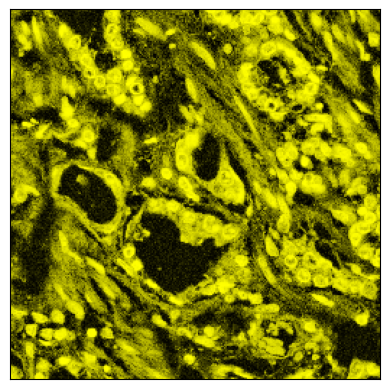

In [164]:
m = 1923
plt.imshow(DRAQ5_input_z[m], cmap = cmap)
plt.xticks([])
plt.yticks([])

In [165]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "black"
color_max    = "green"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_max]
)

([], [])

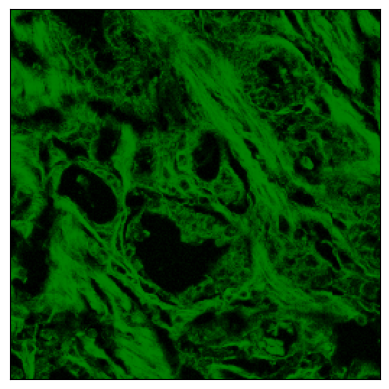

In [166]:
plt.imshow(Eosin_input_z[m], cmap = cmap)
plt.xticks([])
plt.yticks([])

([], [])

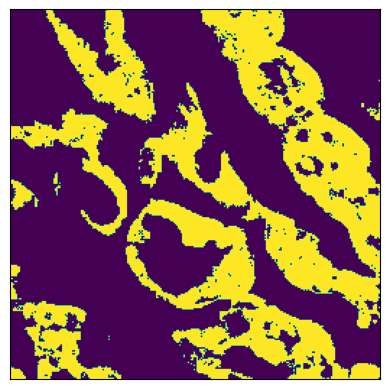

In [167]:
plt.imshow(masks_segm2[m], vmin = 0, vmax = 2)
plt.xticks([])
plt.yticks([])

([], [])

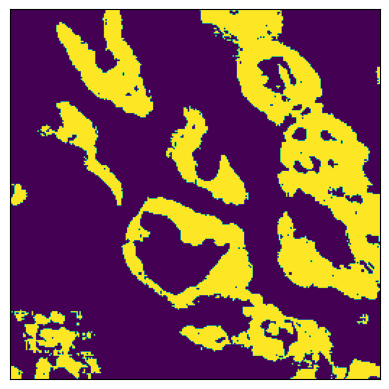

In [168]:
plt.imshow(pred_values2[m], vmin = 0, vmax = 2)
plt.xticks([])
plt.yticks([])

In [193]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "black"
color_max    = "yellow"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_max]
)

([], [])

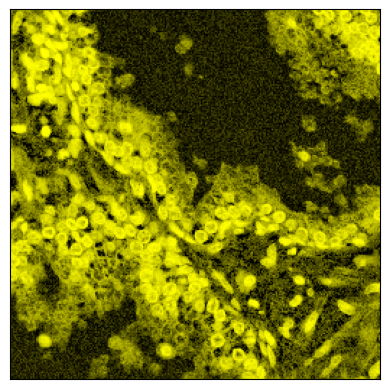

In [194]:
m = 5909
plt.imshow(DRAQ5_input_z[m], cmap = cmap)
plt.xticks([])
plt.yticks([])

In [195]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "black"
color_max    = "green"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_max]
)

([], [])

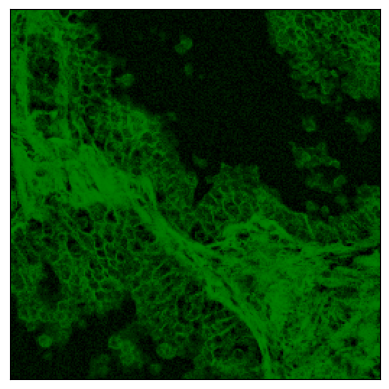

In [196]:
plt.imshow(Eosin_input_z[m], cmap = cmap)
plt.xticks([])
plt.yticks([])

([], [])

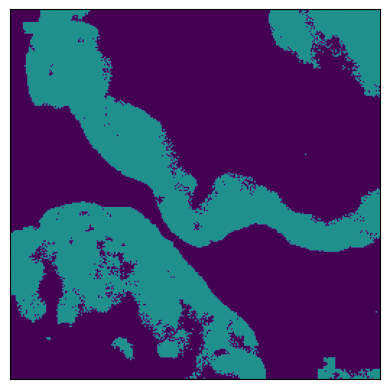

In [197]:
plt.imshow(masks_segm2[m], vmin = 0, vmax = 2)
plt.xticks([])
plt.yticks([])

([], [])

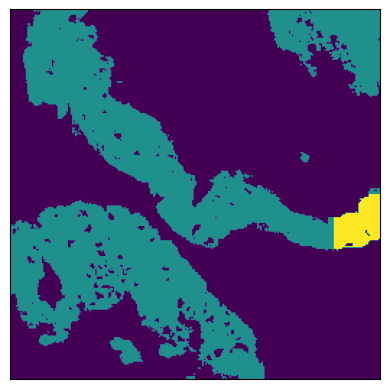

In [198]:
plt.imshow(pred_values2[m], vmin = 0, vmax = 2)
plt.xticks([])
plt.yticks([])

In [111]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "black"
color_max    = "yellow"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_max]
)

([], [])

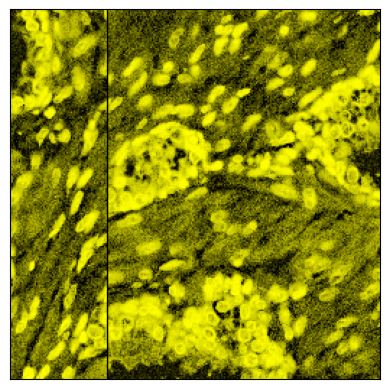

In [112]:
m = 2329
plt.imshow(DRAQ5_input_z[m], cmap = cmap)
plt.xticks([])
plt.yticks([])

In [113]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "black"
color_max    = "green"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_max]
)

([], [])

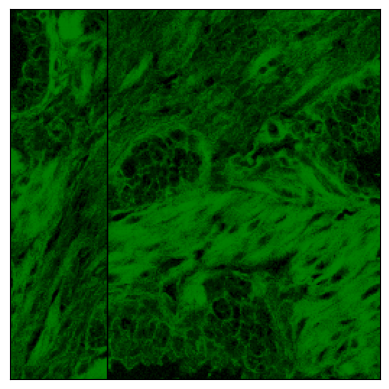

In [114]:
plt.imshow(Eosin_input_z[m], cmap = cmap)
plt.xticks([])
plt.yticks([])

([], [])

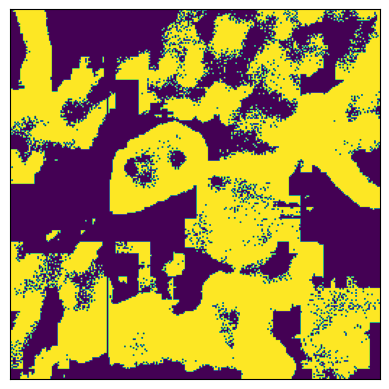

In [115]:
plt.imshow(masks_segm2[m], vmin = 0, vmax = 2)
plt.xticks([])
plt.yticks([])

([], [])

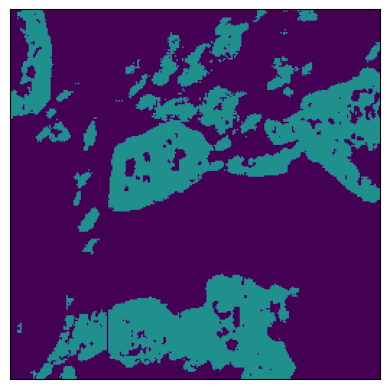

In [116]:
plt.imshow(pred_values2[m], vmin = 0, vmax = 2)
plt.xticks([])
plt.yticks([])

In [303]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "black"
color_max    = "yellow"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_max]
)

([], [])

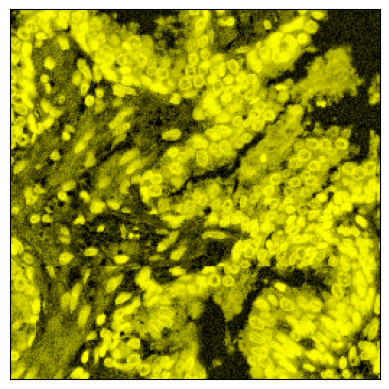

In [304]:
m = 3715
plt.imshow(DRAQ5_input_z[m], cmap = cmap)
plt.xticks([])
plt.yticks([])

In [305]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "black"
color_max    = "green"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_max]
)

([], [])

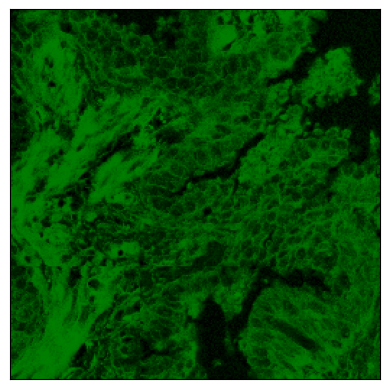

In [306]:
plt.imshow(Eosin_input_z[m], cmap = cmap)
plt.xticks([])
plt.yticks([])

([], [])

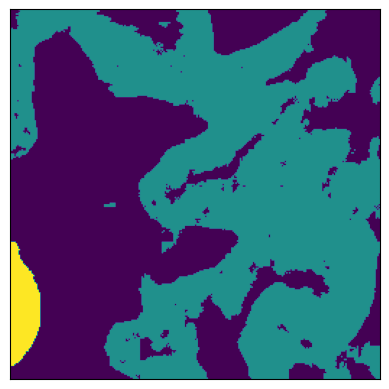

In [307]:
plt.imshow(masks_segm2[m], vmin = 0, vmax = 2)
plt.xticks([])
plt.yticks([])

([], [])

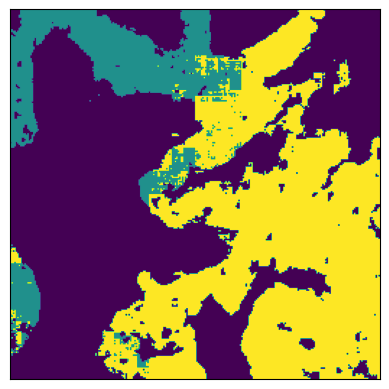

In [308]:
plt.imshow(pred_values2[np.argwhere(classif3 == 0)[624][0]], vmin = 0, vmax = 2)
plt.xticks([])
plt.yticks([])